# **Next-Frame Prediction Using Convolutional LSTM**

## **Important Libraries**

### **Install**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics moviepy opendatasets torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 165.1 MB/s eta 0:00:00


### **Import**

In [ ]:
import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.image import (
    PeakSignalNoiseRatio,
    StructuralSimilarityIndexMeasure
)
from torchmetrics.regression import MeanAbsoluteError

from google.colab.patches import cv2_imshow
from IPython.display import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchvision import transforms
from torchvision.transforms import Compose
from torchvision.datasets.utils import download_url

import imageio.v2 as imageio
from moviepy.editor import VideoFileClip

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import math
import copy
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [ ]:
CLIP_GRAD      = 2
FPS            = 4
BATCH_SIZE     = 8
EPOCH          = 16
IMAGE_SIZE     = 32

In [ ]:
REDUCE_LR_FACTOR        = 1/2
EARLY_STOPPING_PATIENCE = 1/4
REDUCE_LR_PATIENCE      = 1/16
LEARNING_RATE           = 1/512

In [ ]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)

EXPERIMENT_DIR = "experiment/"
DATASET_DIR = "experiment/dataset"
DATASET = "mnist_test_seq.npy"

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 388540358


## **Dataset**

In [ ]:
#### Added
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import os
# Download the dataset
od.download("https://www.kaggle.com/datasets/israafahmy/fruitq")

# Define the path to the downloaded dataset
dataset_path = "/content/fruitq/FruQ-multi/BananaDB"

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/israafahmy/fruitq


100%|██████████| 4.34G/4.34G [00:48<00:00, 96.1MB/s]


Dataset length: 612
Dataset split: val
9


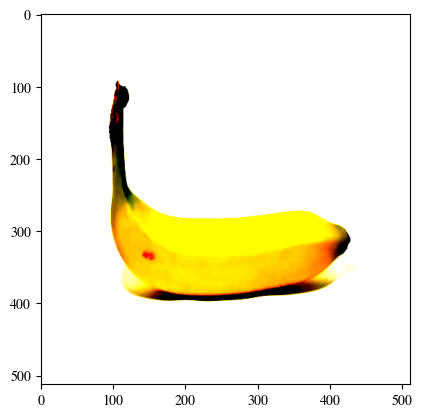

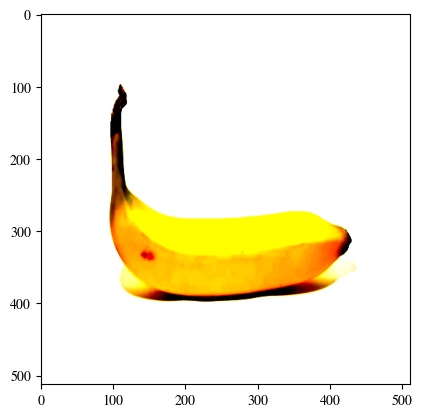

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import glob


class BananaDataset(Dataset):
    def __init__(self, root_dir, sequence_length, transform=None, flip=None, split="inference"):
        """
        Args:
            root_dir (str): Main directory containing subfolders with images.
            sequence_length (int): Number of consecutive images to use as input.
            transform (callable, optional): Optional transform to be applied to the images.
        """
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.flip = flip
        self.split = split
        self.inference_index = None
        self.start = None
        self.end = None
        # Recursively gather all image paths, sorted by timeframe
        self.image_paths = sorted(
            glob.glob(os.path.join(root_dir, "**", "*.png"), recursive=True),
            key=lambda x: int(os.path.basename(x).replace("Image", "").replace(".png", ""))
        )
        print(f"Dataset length: {len(self.image_paths)}")

    def __len__(self):
        if self.split == "inference":
            return 1
        try:
          if self.end-self.start - self.sequence_length >0:
            return self.end-self.start - self.sequence_length
          else:
            return 0
        except:
          return len(self.image_paths) - self.sequence_length

    def __getitem__(self, idx):
        """
        Returns:
            inputs (Tensor): Sequence of images as input.
            target (Tensor): The next image in the sequence as the target.
        """
        from PIL import Image
        if self.split != "inference":

            # Load a sequence of images
            images = []

            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            images.append(image)

            # Load the target image
            target_path = self.image_paths[idx + self.sequence_length]
            target_image = Image.open(target_path).convert("RGB")
            if self.transform:
                target_image = self.transform(target_image)
            target_image = target_image.unsqueeze(0)

            stack = torch.stack(images)  # (T, C, H, W)
            if self.flip:
              stack = stack.permute(*self.flip)  # (C, T, H, W)
              target_image = target_image.permute(*self.flip)
            return stack, target_image

        # Load the target image
        target_path = self.image_paths[idx + self.sequence_length]
        target_image = Image.open(target_path).convert("RGB")
        target_image = self.transform(target_image)
        target_image = target_image.unsqueeze(0)
        target_image = target_image.permute(*self.flip)
        return target_image

    def __call__(self, split):
        assert split is not None and split in [
            "train",
            "val",
            "test",
            "inference",
        ], "Please define the dataset split: 'train', 'val', 'test', or 'inference'"

        self.split = split

        print(f"Dataset split: {self.split}")

        len_raw_data = len(self.image_paths)

        if self.split == "train":
            self.start = 0
            self.end = int((1 - 0.2) * (1 - 0.1) * len_raw_data)
        elif self.split == "val":
            self.start = int((1 - 0.2) * (1 - 0.1) * len_raw_data)
            self.end = int((1 - 0.2) * len_raw_data)
        elif self.split in ["test", "inference"]:
            self.start = int((1 - 0.2) * len_raw_data)
            self.end = len_raw_data

        if self.split == "inference":
            self.inference_index = random.randint(self.start, self.end - 1)

        return self

# Define transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

A = BananaDataset(dataset_path, 40, transform, (1,0,2,3), split="test")
print(len(A("val")))
# 1, 3, 64, 64
from matplotlib import pyplot as plt
plt.imshow(A[0][0].permute(1,2,3,0)[0])
plt.show()

plt.imshow(A[0][1].permute(1,2,3,0)[0])
plt.show()

### **Download and Prepare**

### **Utils**

In [ ]:
def _is_tensor_video_clip(clip):
    if not torch.is_tensor(clip):
        raise TypeError("clip should be Tensor. Got %s" % type(clip))

    if not clip.ndimension() == 4:
        raise ValueError("clip should be 4D. Got %dD" % clip.dim())

    return True


def resize(clip, target_size, interpolation_mode):
    assert len(target_size) == 2, "target size should be tuple (height, width)"
    return F.interpolate(clip, size=target_size, mode=interpolation_mode)


def to_tensor(clip):
    """
    Convert tensor data type from uint8 to float, divide value by 255.0 and
    permute the dimenions of clip tensor
    Args:
        clip (torch.tensor, dtype=torch.uint8): Size is (T, H, W, C)
    Return:
        clip (torch.tensor, dtype=torch.float): Size is (C, T, H, W)
    """
    _is_tensor_video_clip(clip)
    if not clip.dtype == torch.uint8:
        raise TypeError(
            "clip tensor should have data type uint8. Got %s" % str(clip.dtype)
        )
    return clip.float().permute(3, 0, 1, 2) / 255.0


class ToTensor(object):
    """
    Convert tensor data type from uint8 to float, divide value by 255.0 and
    permute the dimenions of clip tensor
    """

    def __init__(self):
        pass

    def __call__(self, clip):
        """
        Args:
            clip (torch.tensor, dtype=torch.uint8): Size is (T, H, W, C)
        Return:
            clip (torch.tensor, dtype=torch.float): Size is (C, T, H, W)
        """
        return to_tensor(clip)

    def __repr__(self):
        return self.__class__.__name__


class Resize(object):
    def __init__(self, size, interpolation_mode="bilinear"):
        self.size = size
        self.interpolation_mode = interpolation_mode

    def __call__(self, clip):
        return resize(clip, self.size, self.interpolation_mode)

    def __repr__(self):
        return self.__class__.__name__

### **Moving MNIST Dataset**

### **Load**

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#MovingMNISTDataset = MovingMNISTDataset()
MovingMNISTDataset = BananaDataset(dataset_path, 40, transform, (1,0,2,3))

Dataset length: 612


## **Our Model**

### **Utils**

In [ ]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Convolutional LSTM**

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size

        self.conv_ii = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )
        self.conv_hi = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )

        self.conv_if = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )
        self.conv_hf = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )

        self.conv_ig = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )
        self.conv_hg = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )

        self.conv_io = nn.Conv2d(
            self.input_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )
        self.conv_ho = nn.Conv2d(
            self.hidden_channels,
            self.hidden_channels,
            self.kernel_size,
            padding=self.kernel_size // 2,
            bias=bias,
        )

    def forward(self, x, hidden_state):
        h_prev, c_prev = hidden_state

        i = torch.sigmoid(self.conv_ii(x) + self.conv_hi(h_prev))
        f = torch.sigmoid(self.conv_if(x) + self.conv_hf(h_prev))
        g = F.relu(self.conv_ig(x) + self.conv_hg(h_prev))
        o = torch.sigmoid(self.conv_io(x) + self.conv_ho(h_prev))
        c = f * c_prev + i * g
        h = o * F.relu(c)

        return h, c

In [ ]:
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTM, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        # Single ConvLSTM layer
        self.conv_lstm_cell = ConvLSTMCell(
            self.input_channels, self.hidden_channels, kernel_size, bias
        )

    def forward(self, x):
        batch_size, channels, sequence_length, height, width = x.size()

        # Initialize hidden state and cell state
        h = torch.zeros(batch_size, self.hidden_channels, height, width).to(x.device)
        c = torch.zeros(batch_size, self.hidden_channels, height, width).to(x.device)

        outputs = list()

        # Process each time step in the sequence
        for t in range(sequence_length):
            h, c = self.conv_lstm_cell(x[:, :, t, :, :], (h, c))
            outputs.append(h)

        outputs = torch.stack(outputs, dim=0).permute(1, 2, 0, 3, 4).contiguous()

        return outputs

In [ ]:
class NextFramePredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        val = 100
        self.convlstm0 = nn.Sequential(
            ConvLSTM(3, val, 5),  # Modified line
            nn.BatchNorm3d(val),
        )
        self.convlstm1 = nn.Sequential(
            ConvLSTM(val, val, 3),
            nn.BatchNorm3d(val),
        )
        self.convlstm2 = nn.Sequential(
            ConvLSTM(val, val, 1),
            nn.BatchNorm3d(val),
        )
        self.final = ConvLSTM(val, 3, 1)

    def forward(self, x):
        x = self.convlstm0(x)
        x = self.convlstm1(x)
        x = self.convlstm2(x)

        return self.final(x)

In [ ]:
MODEL = NextFramePredictionModel
MODEL_NAME = MODEL.__name__
BEST_MODEL_PATH = os.path.join(EXPERIMENT_DIR,f"{MODEL_NAME}_best.ckpt")

### **Wrapper**

In [ ]:
class ModelWrapper(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.arch = MODEL()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.automatic_optimization = False

        self.train_mae = MeanAbsoluteError()
        self.val_mae = MeanAbsoluteError()
        self.test_mae = MeanAbsoluteError()

        self.train_psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.val_psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.test_psnr = PeakSignalNoiseRatio(data_range=1.0)

        self.train_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.val_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.test_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

        self.train_loss = list()
        self.val_loss = list()

        self.train_mae_list = list()
        self.val_mae_list = list()

        self.train_psnr_list = list()
        self.val_psnr_list = list()

        self.train_ssim_list = list()
        self.val_ssim_list = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_mae_recorder = AvgMeter()
        self.val_mae_recorder = AvgMeter()

        self.train_psnr_recorder = AvgMeter()
        self.val_psnr_recorder = AvgMeter()

        self.train_ssim_recorder = AvgMeter()
        self.val_ssim_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        #print(x.shape)
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)

        loss = F.mse_loss(y_hat, y)

        self.train_mae.update(y_hat.detach().view(-1), y.view(-1))
        mae = self.train_mae.compute().data.cpu()
        self.train_psnr.update(
            torch.clamp(
                y_hat.detach().transpose(1,2).contiguous().view(
                    -1, y_hat.size(1), y_hat.size(3), y_hat.size(4)
                ),
                0.,
                1.,
            ),
            y.transpose(1,2).contiguous().view(
                -1, y.size(1), y.size(3), y.size(4)
            ),
        )
        psnr = self.train_psnr.compute().data.cpu()

        self.train_ssim.update(
            torch.clamp(
                y_hat.detach().transpose(1,2).contiguous().view(
                    -1, y_hat.size(1), y_hat.size(3), y_hat.size(4)
                ),
                0.,
                1.,
            ),
            y.transpose(1,2).contiguous().view(
                -1, y.size(1), y.size(3), y.size(4)
            ),
        )
        ssim = self.train_ssim.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        torch.nn.utils.clip_grad_norm_(self.parameters(), CLIP_GRAD)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mae", mae, prog_bar=True)
        self.log("train_psnr", psnr, prog_bar=True)
        self.log("train_ssim", ssim, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_mae_recorder.update(mae)
        self.train_psnr_recorder.update(psnr)
        self.train_ssim_recorder.update(ssim)

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_mae_list.append(self.train_mae_recorder.show().data.cpu().numpy())
        self.train_mae_recorder = AvgMeter()

        self.train_psnr_list.append(self.train_psnr_recorder.show().data.cpu().numpy())
        self.train_psnr_recorder = AvgMeter()

        self.train_ssim_list.append(self.train_ssim_recorder.show().data.cpu().numpy())
        self.train_ssim_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch[0], batch[-1]
        y_hat = self(x)

        loss = F.mse_loss(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_mae.update(y_hat.view(-1), y.view(-1))
            mae = self.val_mae.compute().data.cpu()

            self.val_psnr.update(
                torch.clamp(
                    y_hat.transpose(1,2).contiguous().view(
                        -1, y_hat.size(1), y_hat.size(3), y_hat.size(4)
                    ),
                    0.,
                    1.,
                ),
                y.transpose(1,2).contiguous().view(
                    -1, y.size(1), y.size(3), y.size(4)
                ),
            )
            psnr = self.val_psnr.compute().data.cpu()

            self.val_ssim.update(
                torch.clamp(
                    y_hat.transpose(1,2).contiguous().view(
                        -1, y_hat.size(1), y_hat.size(3), y_hat.size(4)
                    ),
                    0.,
                    1.,
                ),
                y.transpose(1,2).contiguous().view(
                    -1, y.size(1), y.size(3), y.size(4)
                ),
            )
            ssim = self.val_ssim.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_mae", mae, prog_bar=True)
            self.log("val_psnr", psnr, prog_bar=True)
            self.log("val_ssim", ssim, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_mae_recorder.update(mae)
            self.val_psnr_recorder.update(psnr)
            self.val_ssim_recorder.update(ssim)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            mae = self.val_mae_recorder.show().data.cpu().numpy()
            sch = self.lr_schedulers()
            sch.step(mae)
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now > lr_now_:
                self.lr_now = lr_now_
                print(
                    f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_} - Epoch: {self.current_epoch}"
                )
            self.val_mae_list.append(mae)
            self.val_mae_recorder = AvgMeter()

            psnr = self.val_psnr_recorder.show().data.cpu().numpy()
            self.val_psnr_list.append(psnr)
            self.val_psnr_recorder = AvgMeter()

            ssim = self.val_ssim_recorder.show().data.cpu().numpy()
            self.val_ssim_list.append(ssim)
            self.val_ssim_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)

        loss = F.mse_loss(y_hat, y)
        self.test_mae.update(y_hat.view(-1), y.view(-1))
        self.test_psnr.update(
            torch.clamp(
                y_hat.transpose(1,2).contiguous().view(
                    -1, y_hat.size(1), y_hat.size(3), y_hat.size(4)
                ),
                0.,
                1.,
            ),
            y.transpose(1,2).contiguous().view(
                -1, y.size(1), y.size(3), y.size(4)
            ),
        )
        self.test_ssim.update(
            y_hat.transpose(1,2).contiguous().view(
                -1, y_hat.size(1), y_hat.size(3), y_hat.size(4)
            ),
            y.transpose(1,2).contiguous().view(
                -1, y.size(1), y.size(3), y.size(4)
            ),
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_mae",
            self.test_mae.compute(),
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_psnr",
            self.test_psnr.compute(),
            prog_bar=True,
            logger=True,
        )
        self.log(
            "test_ssim",
            self.test_ssim.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # MAE
        mae_img_file = f"experiment/training/{MODEL_NAME}_mae_plot.png"
        plt.plot(self.train_mae_list, color="r", label="train")
        plt.plot(self.val_mae_list, color="b", label="validation")
        plt.title("MAE Curves")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid()
        plt.savefig(mae_img_file)
        plt.clf()
        img = cv2.imread(mae_img_file)
        cv2_imshow(img)

        # PSNR
        psnr_img_file = f"experiment/training/{MODEL_NAME}_psnr_plot.png"
        plt.plot(self.train_psnr_list, color="r", label="train")
        plt.plot(self.val_psnr_list, color="b", label="validation")
        plt.title("PSNR Curves")
        plt.xlabel("Epoch")
        plt.ylabel("PSNR")
        plt.legend()
        plt.grid()
        plt.savefig(psnr_img_file)
        plt.clf()
        img = cv2.imread(psnr_img_file)
        cv2_imshow(img)

        # SSIM
        ssim_img_file = f"experiment/training/{MODEL_NAME}_ssim_plot.png"
        plt.plot(self.train_ssim_list, color="r", label="train")
        plt.plot(self.val_ssim_list, color="b", label="validation")
        plt.title("SSIM Curves")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM")
        plt.legend()
        plt.grid()
        plt.savefig(ssim_img_file)
        plt.clf()
        img = cv2.imread(ssim_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=MovingMNISTDataset("train"),
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=MovingMNISTDataset("val"),
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=MovingMNISTDataset("test"),
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="min",
                factor=REDUCE_LR_FACTOR,
                patience=int(math.ceil(REDUCE_LR_PATIENCE * self.max_epoch)),
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]



## **Training**

INFO: Seed set to 388540358
INFO:lightning.fabric.utilities.seed:Seed set to 388540358
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type                             | Params | Mode 
------------------------------------------------------------------------
0 | arch       | NextFramePredictionModel         | 1.8 M  | train
1 | train_mae  | MeanAbsoluteError                | 0      | train
2 | val_mae    | MeanAbsoluteError                | 0      | train
3 | test_mae   | MeanAbsoluteError                | 0  

NextFramePredictionModel


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Dataset split: val
Dataset split: train


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[NextFramePredictionModel] Learning Rate Changed: 0.001953125 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=16` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


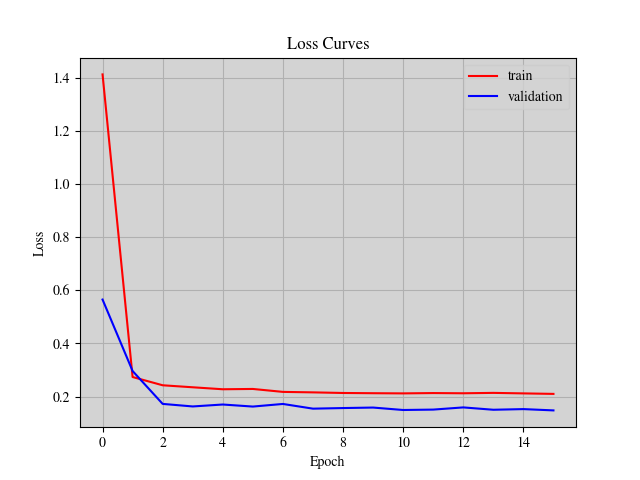

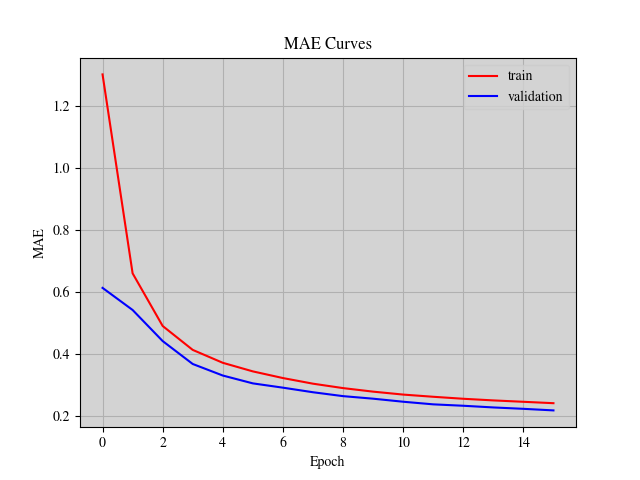

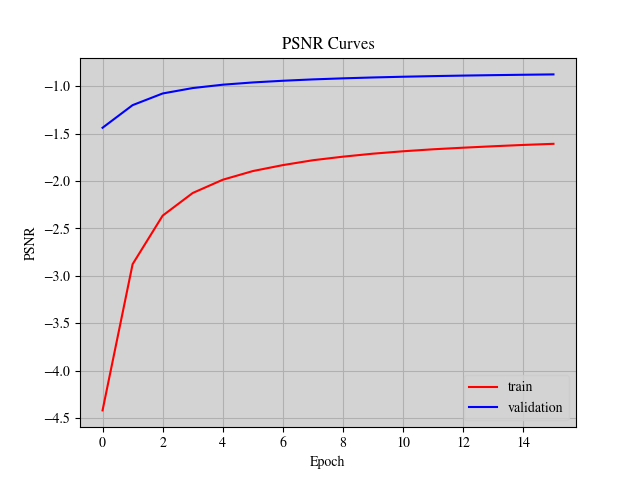

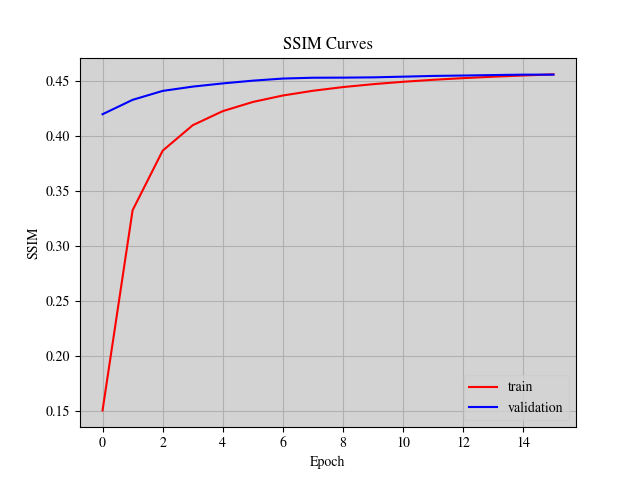

<Figure size 640x480 with 0 Axes>

In [ ]:
def _train_loop():
    seed_everything(SEED, workers=True)

    model = ModelWrapper()

    checkpoint = ModelCheckpoint(
        monitor='val_mae',
        dirpath=EXPERIMENT_DIR,
        mode='min',
        filename=f"{MODEL_NAME}_best",
    )
    print(MODEL_NAME)
    early_stopping = EarlyStopping(
        monitor="val_mae",
        min_delta=0.00,
        patience=int(EARLY_STOPPING_PATIENCE * EPOCH),
        verbose=False,
        mode="min",
    )

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=[checkpoint, early_stopping],
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [ ]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = ModelWrapper()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/NextFramePredictionModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/NextFramePredictionModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/NextFramePredictionModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at experiment/NextFramePredictionModel_best.ckpt


Dataset split: test


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1468290090560913     │
│         test_mae          │    0.12859337031841278    │
│         test_psnr         │    -0.7982052564620972    │
│         test_ssim         │    0.8368481397628784     │
└───────────────────────────┴───────────────────────────┘

## **Inference**

### **Initialization**

In [ ]:
model = ModelWrapper.load_from_checkpoint(BEST_MODEL_PATH)
model.eval()

ModelWrapper(
  (arch): NextFramePredictionModel(
    (convlstm0): Sequential(
      (0): ConvLSTM(
        (conv_lstm_cell): ConvLSTMCell(
          (conv_ii): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_hi): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_if): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_hf): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_ig): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_hg): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_io): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv_ho): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        )
      )
      (1): BatchNorm3d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convlstm1): Sequential(
      (0): 

### **Prediction**

Dataset split: inference
Input


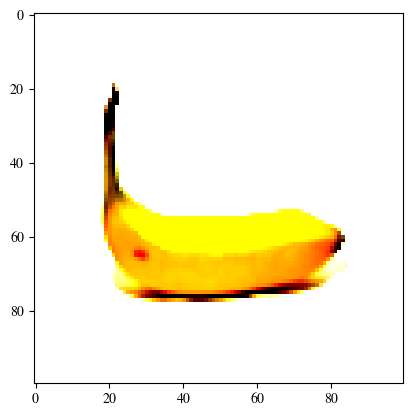

Output


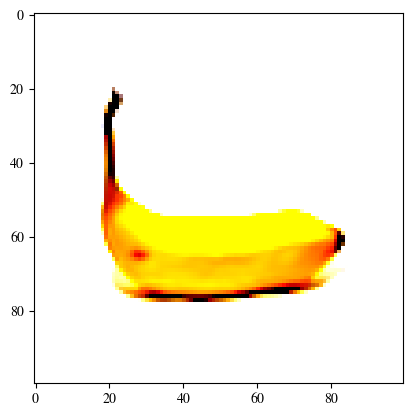

Expected Output


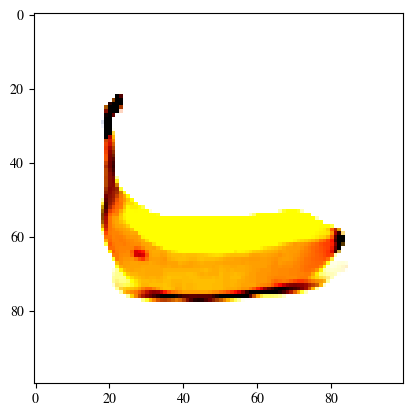

Dataset split: inference
Input


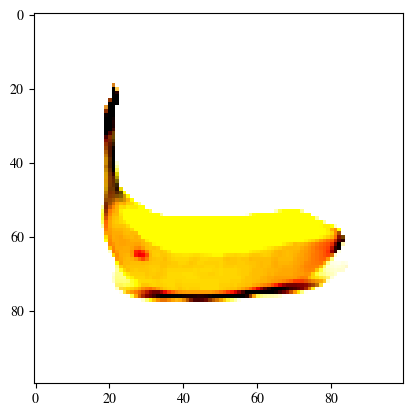

Output


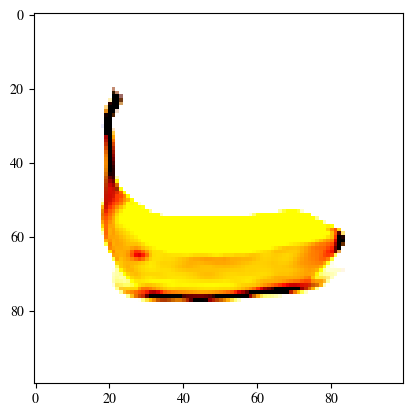

Expected Output


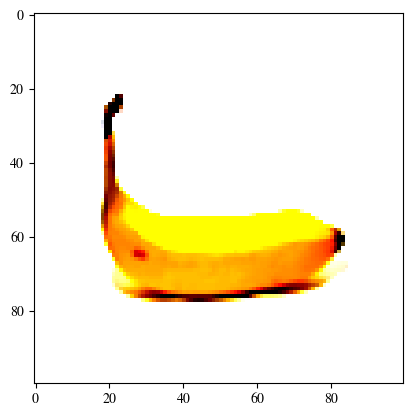

In [ ]:
from matplotlib import pyplot as plt

NUM_SAMPLE = 2

prev = None
for sample_idx in range(NUM_SAMPLE):
    video_frames = list()
    InferenceDataset = copy.deepcopy(MovingMNISTDataset("inference"))
    x = InferenceDataset[sample_idx].unsqueeze(0)
    y = InferenceDataset[sample_idx+40].unsqueeze(0)

    y_hat = torch.clamp(
            model(x.to("cpu" if not torch.cuda.is_available() else "cuda")), 0.0, 1.0
        )
    print("Input")
    plt.imshow(x.permute(0,2,3,4,1)[0][0])
    plt.show()
    print("Output")
    y_hat = y_hat.cpu()
    plt.imshow(y_hat.permute(0,2,3,4,1)[0][0].detach().numpy())
    plt.show()
    print("Expected Output")
    plt.imshow(y.permute(0,2,3,4,1)[0][0])
    plt.show()



In [ ]:
'''		ModelWrapper(
		  (arch): NextFramePredictionModel(
		    (convlstm0): Sequential(
		      (0): ConvLSTM(
		        (conv_lstm_cell): ConvLSTMCell(
		          (conv_ii): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
		          (conv_hi): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
		          (conv_if): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
		          (conv_hf): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
		          (conv_ig): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
		          (conv_hg): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
		          (conv_io): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
		          (conv_ho): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
		        )
		      )
		      (1): BatchNorm3d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
		    )
		    (convlstm1): Sequential(
		      (0): ConvLSTM(
		        (conv_lstm_cell): ConvLSTMCell(
		          (conv_ii): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		          (conv_hi): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		          (conv_if): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		          (conv_hf): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		          (conv_ig): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		          (conv_hg): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		          (conv_io): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		          (conv_ho): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		        )
		      )
		      (1): BatchNorm3d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
		    )
		    (convlstm2): Sequential(
		      (0): ConvLSTM(
		        (conv_lstm_cell): ConvLSTMCell(
		          (conv_ii): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
		          (conv_hi): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
		          (conv_if): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
		          (conv_hf): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
		          (conv_ig): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
		          (conv_hg): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
		          (conv_io): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
		          (conv_ho): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
		        )
		      )
		      (1): BatchNorm3d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
		    )
		    (final): ConvLSTM(
		      (conv_lstm_cell): ConvLSTMCell(
		        (conv_ii): Conv2d(100, 3, kernel_size=(1, 1), stride=(1, 1))
		        (conv_hi): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
		        (conv_if): Conv2d(100, 3, kernel_size=(1, 1), stride=(1, 1))
		        (conv_hf): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
		        (conv_ig): Conv2d(100, 3, kernel_size=(1, 1), stride=(1, 1))
		        (conv_hg): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
		        (conv_io): Conv2d(100, 3, kernel_size=(1, 1), stride=(1, 1))
		        (conv_ho): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
		      )
		    )
		  )
		  (train_mae): MeanAbsoluteError()
		  (val_mae): MeanAbsoluteError()
		  (test_mae): MeanAbsoluteError()
		  (train_psnr): PeakSignalNoiseRatio()
		  (val_psnr): PeakSignalNoiseRatio()
		  (test_psnr): PeakSignalNoiseRatio()
		  (train_ssim): StructuralSimilarityIndexMeasure()
		  (val_ssim): StructuralSimilarityIndexMeasure()
		  (test_ssim): StructuralSimilarityIndexMeasure()
		)'''

'\t\tModelWrapper(\n\t\t  (arch): NextFramePredictionModel(\n\t\t    (convlstm0): Sequential(\n\t\t      (0): ConvLSTM(\n\t\t        (conv_lstm_cell): ConvLSTMCell(\n\t\t          (conv_ii): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n\t\t          (conv_hi): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n\t\t          (conv_if): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n\t\t          (conv_hf): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n\t\t          (conv_ig): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n\t\t          (conv_hg): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n\t\t          (conv_io): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n\t\t          (conv_ho): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))\n\t\t        )\n\t\t      )\n\t\t      (1): BatchNorm3d(100, eps=1e-05, momentum=0.1, affin